<h3> This notebook walks through the process of building a machine learning model to predict which LLM-generated response a user will prefer. We will use the CRISP-DM (Cross-Industry Standard Process for Data Mining) framework, which provides a structured approach to data mining projects.
The goal is to train a model on train.csv and make predictions on test.csv.

<h5>Import all the necessary Python libraries for data manipulation, visualization, and machine learning.

In [1]:
# For data handling and numerical operations
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# --- NEW: NLTK for text preprocessing ---
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords') # Download the stopwords list

# For building the feature engineering pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- UPDATED: Import new models ---
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier # A powerful gradient boosting model

# For evaluation
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Set a style for all our plots
sns.set_style('whitegrid')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kauch\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<h5>Business Understanding: <br>
The core business problem is to improve Large Language Models (LLMs) by understanding user preferences. When an LLM generates multiple responses to a prompt, we want to automatically predict which one a user would find better. A model that can do this effectively can be used for automated quality control, ranking different responses, or even helping to train better LLMs in the future. <br>
 <br>   
Our task is to predict one of three outcomes:<br>
1. winner_model_a: The user preferred the response from Model A.<br>
2. winner_model_b: The user preferred the response from Model B.<br>
3. winner_tie: The user considered both responses to be of equal quality.</h5>

<h5>Step 1: Data Collection and Loading

Data Available on Kaggle - https://www.kaggle.com/competitions/llm-classification-finetuning/data

--- Training Data Head ---
       id             model_a              model_b  \
0   30192  gpt-4-1106-preview           gpt-4-0613   
1   53567           koala-13b           gpt-4-0613   
2   65089  gpt-3.5-turbo-0613       mistral-medium   
3   96401    llama-2-13b-chat  mistral-7b-instruct   
4  198779           koala-13b   gpt-3.5-turbo-0314   

                                              prompt  \
0  ["Is it morally right to try to have a certain...   
1  ["What is the difference between marriage lice...   
2  ["explain function calling. how would you call...   
3  ["How can I create a test set for a very rare ...   
4  ["What is the best way to travel from Tel-Aviv...   

                                          response_a  \
0  ["The question of whether it is morally right ...   
1  ["A marriage license is a legal document that ...   
2  ["Function calling is the process of invoking ...   
3  ["Creating a test set for a very rare category...   
4  ["The best way to travel fro

C:\Users\kauch\AppData\Local\Temp\ipykernel_20676\2919271927.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')


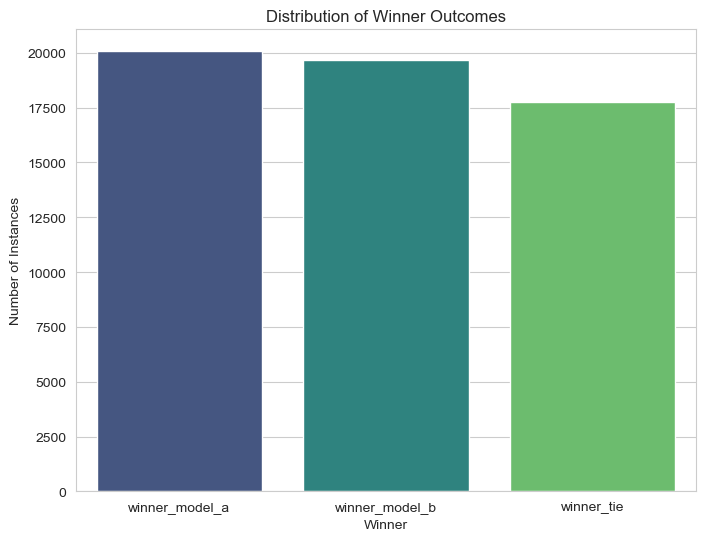

In [2]:
# Load the training and testing datasets from their paths
try:
    train_df = pd.read_csv("data/train.csv")
    test_df = pd.read_csv("data/test.csv")
except FileNotFoundError:
    print("Dataset files not found. Make sure you are running this in a Kaggle environment.")
    # Create empty dataframes to prevent the rest of the code from crashing
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()

if not train_df.empty:
    # Display the first 5 rows of the training data
    print("--- Training Data Head ---")
    print(train_df.head())
    
    # Display a concise summary of the dataframe, including non-null counts and data types
    print("\n--- Training Data Info ---")
    train_df.info()

    # Check the distribution of the winner columns
    print("\n--- Target Variable Distribution ---")
    target_distribution = train_df[['winner_model_a', 'winner_model_b', 'winner_tie']].sum()
    print(target_distribution)
    
    # Visualize the distribution of the winners
    plt.figure(figsize=(8, 6))
    sns.barplot(x=target_distribution.index, y=target_distribution.values, palette='viridis')
    plt.title('Distribution of Winner Outcomes')
    plt.ylabel('Number of Instances')
    plt.xlabel('Winner')
    plt.show()

The three target variables show that there is good distribution of data.

<h5> Step 2: Data Preparation <br>
<br>
1. Create new numerical features: add the character length of each response and, crucially, the difference in length between them. This difference can be a very strong signal of user preference.<br>
2. Prepare a single target column .<br>
3. Split the data into training and validation sets.

In [3]:
if not train_df.empty:
    # 1. Create a single, simplified target column 'winner'
    def get_winner(row):
        if row['winner_model_a'] == 1:
            return 0 # Model A
        elif row['winner_model_b'] == 1:
            return 1 # Model B
        else:
            return 2 # Tie

    train_df['winner'] = train_df.apply(get_winner, axis=1)

    # --- Create additional numerical features ---
    # These features can provide powerful signals to the model.
    for df in [train_df, test_df]:
        df['prompt_len'] = df['prompt'].str.len()
        df['response_a_len'] = df['response_a'].str.len()
        df['response_b_len'] = df['response_b'].str.len()
        # The difference in length can be a very strong predictor
        df['len_diff'] = df['response_a_len'] - df['response_b_len']

    print("--- Sample of Data with New Features ---")
    print(train_df[['prompt_len', 'response_a_len', 'response_b_len', 'len_diff', 'winner']].head())
    
    # Define our features (X) and target (y)
    # Note: We now use a list of column names for our features
    feature_cols = ['prompt', 'response_a', 'response_b', 'prompt_len', 'response_a_len', 'response_b_len', 'len_diff']
    X = train_df[feature_cols]
    y = train_df['winner']

    # 3. Split the data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

    print(f"\nTraining set size: {X_train.shape[0]}")
    print(f"Validation set size: {X_val.shape[0]}")

--- Sample of Data with New Features ---
   prompt_len  response_a_len  response_b_len  len_diff  winner
0         165            4538            1206      3332       0
1         200            3114            3649      -535       1
2          60             921            1835      -914       2
3          87            3182            1562      1620       0
4          79            1300             772       528       1

Training set size: 40233
Validation set size: 17244


<h5> Step 3: Data Modeling<br>
    <br>
1. Preprocessing Enhancements: Vectorizer to remove stopwords and look at two-word phrases (n-grams), which helps capture more context.<br>
2. Column Transformer: We will use a ColumnTransformer to apply different preprocessing steps to different columns.<br>
3. Models: We will evaluate LogisticRegression, LinearSVC, and LightGBM.

In [4]:
if not train_df.empty:
    # --- NEW: Define English stopwords ---
    stop_words = list(stopwords.words('english'))

    # --- NEW: Create a ColumnTransformer to handle mixed data types ---
    # This preprocessor will apply TfidfVectorizer to each text column
    # and pass the numerical columns through unchanged.
    preprocessor = ColumnTransformer(
        transformers=[
            ('prompt_tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), max_features=2000), 'prompt'),
            ('response_a_tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), max_features=3000), 'response_a'),
            ('response_b_tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1, 2), max_features=3000), 'response_b'),
        ],
        remainder='passthrough' # Keep our numerical columns (prompt_len, etc.)
    )

    # --- UPDATED: Define our models for comparison ---
    models = {
        "Logistic Regression": LogisticRegression(random_state=42, max_iter=1000),
        "Linear SVC": LinearSVC(random_state=42, dual=True, max_iter=1000), # dual=True can be faster
        "LightGBM": LGBMClassifier(random_state=42, verbose=-1)
    }

    # Train and evaluate each model using a Pipeline
    for name, model in models.items():
        # Create the full pipeline
        pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                   ('classifier', model)])
        
        print(f"--- Training {name} ---")
        pipeline.fit(X_train, y_train)
        
        print(f"--- Evaluating {name} ---")
        y_pred = pipeline.predict(X_val)
        
        # Store the trained pipeline for later use
        models[name] = pipeline 
        
        # --- Evaluation metrics will be printed in the next step ---
        accuracy = accuracy_score(y_val, y_pred)
        print(f"Validation Accuracy: {accuracy:.4f}\n")
        print(classification_report(y_val, y_pred, target_names=['Model A Wins', 'Model B Wins', 'Tie']))

--- Training Logistic Regression ---


C:\Users\kauch\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


--- Evaluating Logistic Regression ---
Validation Accuracy: 0.4378

              precision    recall  f1-score   support

Model A Wins       0.46      0.48      0.47      6019
Model B Wins       0.45      0.50      0.47      5896
         Tie       0.40      0.33      0.36      5329

    accuracy                           0.44     17244
   macro avg       0.43      0.43      0.43     17244
weighted avg       0.43      0.44      0.43     17244

--- Training Linear SVC ---


C:\Users\kauch\anaconda3\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


--- Evaluating Linear SVC ---
Validation Accuracy: 0.3377

              precision    recall  f1-score   support

Model A Wins       0.34      0.62      0.44      6019
Model B Wins       0.29      0.16      0.20      5896
         Tie       0.39      0.22      0.28      5329

    accuracy                           0.34     17244
   macro avg       0.34      0.33      0.31     17244
weighted avg       0.34      0.34      0.31     17244

--- Training LightGBM ---
--- Evaluating LightGBM ---
Validation Accuracy: 0.4678

              precision    recall  f1-score   support

Model A Wins       0.48      0.53      0.50      6019
Model B Wins       0.48      0.51      0.49      5896
         Tie       0.44      0.35      0.39      5329

    accuracy                           0.47     17244
   macro avg       0.46      0.46      0.46     17244
weighted avg       0.47      0.47      0.46     17244



C:\Users\kauch\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


<h5> Step 4: Evaluation<br>
<br>
With the model trained, evaluate how it performs on data it has never seen before (validation set). Check accuracy and look at a more detailed report to understand its strengths and weaknesses.

--- Detailed Evaluation for Best Model: Linear SVC ---


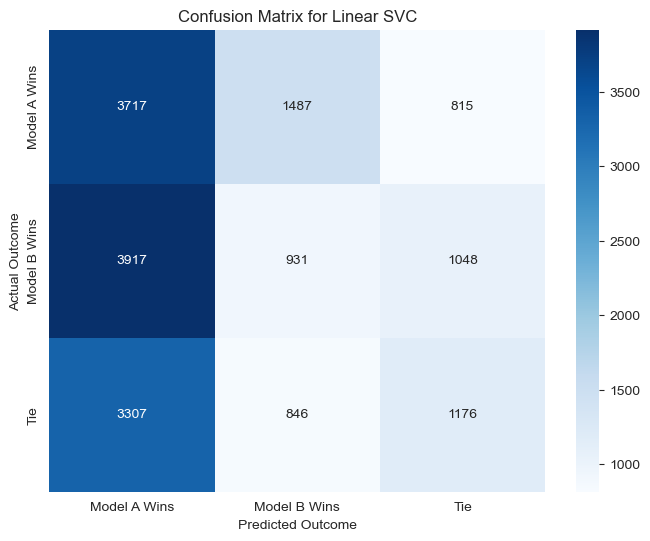

In [5]:
# --- Let's choose the best model for a detailed look at its confusion matrix ---
best_model_name = "Linear SVC"
best_pipeline = models[best_model_name]

print(f"--- Detailed Evaluation for Best Model: {best_model_name} ---")

# Regenerate predictions for the best model to create the confusion matrix
y_pred_best = best_pipeline.predict(X_val)

# Visualize the results with a Confusion Matrix
cm = confusion_matrix(y_val, y_pred_best)
plt.figure(figsize=(8, 6))
class_names = ['Model A Wins', 'Model B Wins', 'Tie']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix for {best_model_name}')
plt.ylabel('Actual Outcome')
plt.xlabel('Predicted Outcome')
plt.show()